In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from scipy import optimize
from scipy import stats
from scipy import interpolate

In [2]:
def u(c):
    return np.log(c)

def du_dc(c):
    return 1./c
# f
def f(A, k):
    return np.exp(A)*k**0.3 + 0.5*k

# Derivative of f
def df_dx(A, k):
    return 0.3*np.exp(A)*k**(-0.7) + 0.5


In [3]:
def evaluate_expectation(g, a_today, a_lb, a_ub, num_quad_nodes, std_dev_eps=0.01):
    eps_lb = a_lb - 0.9*a_today
    eps_ub = a_ub - 0.9*a_today
    
    eps_grid = np.linspace(eps_lb, eps_ub, num_quad_nodes)
    a_next_grid = 0.9*a_today + eps_grid
    
    g_next_grid = g(a_next_grid)[0,:]
    #print('gn', g_next_grid)
    
    ## Gaussian quadrature
    normal = lambda x: stats.norm.cdf(x, scale = std_dev_eps)
    
    weight_grid = np.zeros(num_quad_nodes)
    weight_grid[0] = normal((eps_grid[0]+eps_grid[1])/2)
    weight_grid[-1] = 1- normal((eps_grid[-2]+eps_grid[-1])/2)
    
    for i in range(1,num_quad_nodes-1):
        weight_grid[i] = normal((eps_grid[i]+eps_grid[i+1])/2)- \
        normal((eps_grid[i-1]+eps_grid[i])/2)
    
    #print(weight_grid)
    integral = np.sum(weight_grid *g_next_grid)
    
    return integral
  
def interpolator(A_vec, k_vec, g_vec):
    tck = interpolate.bisplrep(A_vec, k_vec, g_vec, kx= 3, ky = 3)
    return lambda A, k: interpolate.bisplev(A, k ,tck)



In [4]:
k_min = 0.1
k_max = 16.00
a_lb = -1.
a_ub = 1.
max_iter = 1000
N = 20
N2 = 20
beta = 0.9
num_quad_nodes = 6 ## Not sure
k_grid = np.linspace(k_min, k_max, N)
A_grid =np.linspace(a_lb, a_ub, N2)

kk, AA = np.meshgrid(A_grid, k_grid)

kk = kk.T
AA = AA.T


g_matrix = np.zeros((N, N2))+k_min

ghat = interpolator(AA.flatten(), kk.flatten(), g_matrix.flatten())

In [5]:
def euler_residual(k, a, kprime, ghat):
    
    c = f(k, a) - kprime

    kprimeprime = lambda a_next : ghat(a_next, kprime)
    c_next = lambda a_next : f(a_next, kprime) - kprimeprime(a_next)
    fprime_next = lambda a_next : df_dx(a_next, kprime)
    integrand = lambda a_next : du_dc(c_next(a_next)) * fprime_next(a_next)
    
    expectation = evaluate_expectation(integrand, a, a_lb, a_ub, num_quad_nodes)
    euler_residual = du_dc(c) - beta * expectation ## du_dc

    return euler_residual

In [6]:
def single_pti(ghat):
    g_matrix = np.zeros((N, N2))
    for i in range(N):
        #print(i)
        for j in range(N2):
            #print(j)
            
            k_curr = kk[i, j]
            A_curr = AA[i, j]
            
            kguess = ghat(A_curr, k_curr)
            
            euler_residual_single = lambda kprime: euler_residual(k_curr, A_curr, kprime, ghat)
            
            g_matrix[i,j] = optimize.fsolve(euler_residual_single, kguess)
    
    return g_matrix

In [7]:
for i in range(max_iter):
    curr_g = single_pti(ghat)
    diff = g_matrix-curr_g
    g_matrix = curr_g.copy()
    ghat = interpolator(AA.flatten(), kk.flatten(), g_matrix.flatten())
    
    if np.abs(diff).max() < 1e-10:
        print('Converged!')
        break
    
    
    

Converged!


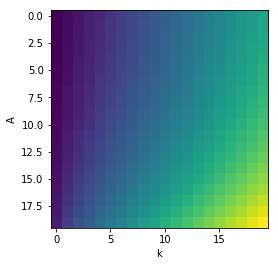

In [8]:
plt.imshow(g_matrix)
plt.xlabel('k')
plt.ylabel('A')
plt.show()

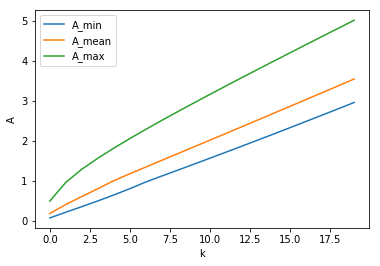

In [9]:
plt.plot(g_matrix[0,:], label='A_min')
plt.plot(g_matrix[10,:], label='A_mean')
plt.plot(g_matrix[19, :], label= 'A_max')
plt.xlabel('k')
plt.ylabel('A')
plt.legend()
plt.show()